In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.utils import compute_class_weight
from sklearn.model_selection import train_test_split
import pickle

plt.style.use('fivethirtyeight')

In [2]:
train_path = "../input/amazon-cleaned-reviews/train.csv"
test_path = "../input/amazon-cleaned-reviews/test.csv"
tokenizer_path = "../input/amazon-cleaned-reviews/tokenizer.pkl"

In [3]:
train = pd.read_csv(train_path)
test = pd.read_csv(test_path)

train.head()

,target,text
0,positive,stuning even for the non gamer this sound trac...
1,positive,the best soundtrack ever to anything i am read...
2,positive,amazing this soundtrack is my favorite music o...
3,positive,excellent soundtrack i truly like this soundtr...
4,positive,remember pull your jaw off the floor after hea...


In [4]:
MAX_FEATURES = 15e3

tokenizer = pickle.load(open(tokenizer_path, "rb"))

train_tokens = tokenizer.texts_to_sequences(train['text'].values)
test_tokens = tokenizer.texts_to_sequences(test['text'].values)

In [16]:
train_text, val_text, train_target, val_target = train_test_split(train_tokens, train['target'], test_size=0.2, random_state=42, stratify=train['target'])

reverse_map = {"positive": 1, "negative": 0}

encoded_train = train_target.map(reverse_map)
encoded_val = val_target.map(reverse_map)
encoded_test = test['target'].map(reverse_map)

train_data = tf.data.Dataset.from_tensor_slices((tf.ragged.constant(train_text), encoded_train)).batch(128)
val_data = tf.data.Dataset.from_tensor_slices((tf.ragged.constant(val_text), encoded_val)).batch(128)
test_data = tf.data.Dataset.from_tensor_slices((tf.ragged.constant(test_tokens), encoded_test)).batch(128)

In [17]:
def get_callbacks(file_path):
    return [
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', factor=0.3, patience=1, min_lr=0.00001),
        tf.keras.callbacks.ModelCheckpoint(filepath=file_path, monitor='val_loss', mode='min', save_best_only=True),
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', restore_best_weights=True, min_delta=1e-8, patience=3)
    ]

In [18]:
def plot_history(history):
    get_plot_data = lambda metric: [np.arange(len(metric)) + 1, metric]

    plt.figure(figsize=(10,5))

    plt.plot(*get_plot_data(history.history['loss']))
    plt.plot(*get_plot_data(history.history['accuracy']))
    plt.plot(*get_plot_data(history.history['val_loss']))
    plt.plot(*get_plot_data(history.history['val_accuracy']))

    plt.title('Model performance')
    plt.legend(list(history.history.keys())[:-1])
    plt.xlabel('Epoch')
    plt.ylabel('Value')
    plt.show()

In [19]:
def plot_confmat(y_true, predictions):
    labels = ['negative', 'positive']

    conf_mat = confusion_matrix(y_true, predictions, normalize='true')

    plt.figure(figsize=(8,5))
    sns.heatmap(pd.DataFrame(conf_mat, columns=labels, index=labels), annot=True, fmt='.2f')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.title('Confusion matrix of test data')
    plt.show()

In [20]:
class_weight = compute_class_weight(class_weight='balanced', classes=np.unique(train['target']), y=train['target'])
class_weight = dict(enumerate(class_weight))

In [24]:
LSTM_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=[None], dtype=tf.int32, ragged=True),
    tf.keras.layers.Embedding(int(MAX_FEATURES), 128),
    tf.keras.layers.LSTM(2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

LSTM_model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

In [25]:
LSTM_history = LSTM_model.fit(train_data, epochs=15, validation_data=val_data, callbacks=get_callbacks('LSTM_model.h5'), class_weight=class_weight)

Epoch 1/15


/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:449: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential_2/lstm_2/RaggedToTensor/boolean_mask_1/GatherV2:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential_2/lstm_2/RaggedToTensor/boolean_mask/GatherV2:0", shape=(None, 128), dtype=float32), dense_shape=Tensor("gradient_tape/sequential_2/lstm_2/RaggedToTensor/Shape:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


625/625 [==============================] - 98s 152ms/step - loss: 0.4702 - accuracy: 0.8279 - val_loss: 0.3669 - val_accuracy: 0.8729
Epoch 2/15
625/625 [==============================] - 94s 150ms/step - loss: 0.3101 - accuracy: 0.8914 - val_loss: 0.3036 - val_accuracy: 0.8887
Epoch 3/15
625/625 [==============================] - 94s 150ms/step - loss: 0.2513 - accuracy: 0.9101 - val_loss: 0.2867 - val_accuracy: 0.8953
Epoch 4/15
625/625 [==============================] - 94s 151ms/step - loss: 0.2199 - accuracy: 0.9212 - val_loss: 0.2847 - val_accuracy: 0.8973
Epoch 5/15
625/625 [==============================] - 94s 150ms/step - loss: 0.1998 - accuracy: 0.9284 - val_loss: 0.2799 - val_accuracy: 0.8967
Epoch 6/15
625/625 [==============================] - 94s 151ms/step - loss: 0.1850 - accuracy: 0.9332 - val_loss: 0.2803 - val_accuracy: 0.8995
Epoch 7/15
625/625 [==============================] - 95s 152ms/step - loss: 0.1562 - accuracy: 0.9458 - val_loss: 0.2817 - val_accuracy: 0.8

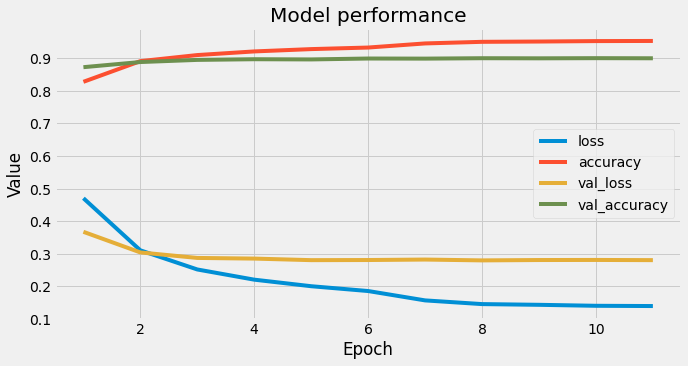

In [26]:
plot_history(LSTM_history)

In [44]:
LSTM_model2 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=[None], dtype=tf.int32, ragged=True),
    tf.keras.layers.Embedding(int(MAX_FEATURES), 128),
    tf.keras.layers.LSTM(2),
    tf.keras.layers.Dense(128, activation='elu'),
#     tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

LSTM_model2.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

In [45]:
LSTM2_history = LSTM_model2.fit(train_data, epochs=15, validation_data=val_data, callbacks=get_callbacks('LSTM_model2.h5'), class_weight=class_weight)

Epoch 1/15


/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:449: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential_6/lstm_6/RaggedToTensor/boolean_mask_1/GatherV2:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential_6/lstm_6/RaggedToTensor/boolean_mask/GatherV2:0", shape=(None, 128), dtype=float32), dense_shape=Tensor("gradient_tape/sequential_6/lstm_6/RaggedToTensor/Shape:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


625/625 [==============================] - 90s 141ms/step - loss: 0.3631 - accuracy: 0.8471 - val_loss: 0.2965 - val_accuracy: 0.8836
Epoch 2/15
625/625 [==============================] - 89s 143ms/step - loss: 0.2511 - accuracy: 0.9030 - val_loss: 0.2677 - val_accuracy: 0.8968
Epoch 3/15
625/625 [==============================] - 88s 141ms/step - loss: 0.2136 - accuracy: 0.9185 - val_loss: 0.2564 - val_accuracy: 0.9003
Epoch 4/15
625/625 [==============================] - 89s 142ms/step - loss: 0.1908 - accuracy: 0.9285 - val_loss: 0.2562 - val_accuracy: 0.9032
Epoch 5/15
625/625 [==============================] - 88s 141ms/step - loss: 0.1719 - accuracy: 0.9371 - val_loss: 0.2688 - val_accuracy: 0.8991
Epoch 6/15
625/625 [==============================] - 88s 141ms/step - loss: 0.1388 - accuracy: 0.9509 - val_loss: 0.2696 - val_accuracy: 0.9039
Epoch 7/15
625/625 [==============================] - 88s 141ms/step - loss: 0.1256 - accuracy: 0.9568 - val_loss: 0.2700 - val_accuracy: 0.9

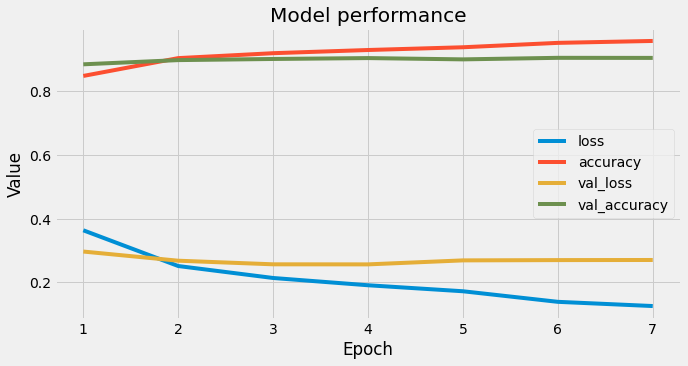

In [46]:
plot_history(LSTM2_history)

In [49]:
best_model = tf.keras.models.load_model("./LSTM_model2.h5")

predictions = best_model.predict(test_data)
y_true = encoded_test
print("ROC AUC score on test set: {0:.4}".format(roc_auc_score(y_true, predictions)))

fpr, tpr, thresholds = roc_curve(y_true, predictions)
optimal_threshold = thresholds[np.argmax(tpr-fpr, axis=0)]
print("Optimal threshold on test set: {0:.4}".format(optimal_threshold))

ROC AUC score on test set: 0.9594
Optimal threshold on test set: 0.5058


In [50]:
print(classification_report(y_true, predictions >= optimal_threshold))

              precision    recall  f1-score   support

           0       0.91      0.91      0.91      1437
           1       0.92      0.91      0.91      1563

    accuracy                           0.91      3000
   macro avg       0.91      0.91      0.91      3000
weighted avg       0.91      0.91      0.91      3000



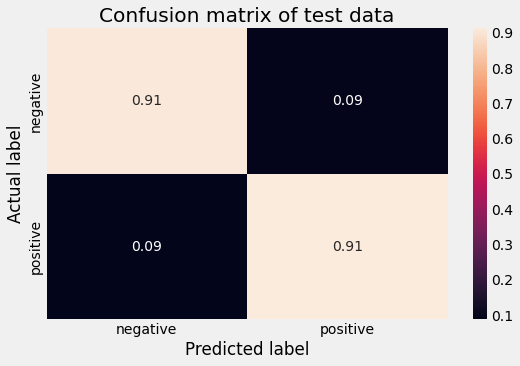

In [54]:
plot_confmat(y_true, predictions >= optimal_threshold)

In [55]:
best_model.predict(
    tf.ragged.constant(
        tokenizer.texts_to_sequences([
            "it s begin to look a lot like xmas, snow everywhere",
            "so inappropriate i will go some where else that is more suitable"
        ])
    )
)

array([[0.9486785 ],
       [0.11362481]], dtype=float32)